# POSNNET user guide

Welcome to the POSNNET user guide. This jupyter notebook introduces the various features of POSNNET and explains how to leverage the full capabilities of the framework.

<u>Contact</u>

Kévin Guyard  
University of Geneva (Switzerland)  
Email: kevin.guyard@live.fr  
Linkedin: https://www.linkedin.com/in/kevin-guyard-8857aa191

<u>Note</u>

- The summary links only work in a local environment. It is recommended to clone or fork the GitHub repository and open it locally.

- Despite the efforts made to make this framework accessible to everyone, including those without specific knowledge in AI, some features may still be difficult to understand—especially when they depend on your specific application needs. In general, you can rely on the default settings, which should provide satisfactory results in most cases. Please don’t hesitate to contact me if you need help or specific guidance.

- In the GitHub repository, you will also find a notebook with a use case example (Use case example.ipynb) and another notebook presenting the scientific validation results (Framework validation.ipynb).

- This framework is the result of several years of research conducted during my Ph.D. in artificial intelligence. It is distributed without any restrictions, except citing the author and sharing the adaptations under the same terms (CC BY-SA 4.0). If this work helps you advance your research, please cite the scientific publication linked to this framework. If you distribute a part or the totality of the framework code, please cite both the scientific publication and the GitHub repository.


<u>Summary of the user guide</u>

[1. What is POSNNET](#1.-What-is-POSNNET)  
[2. Before starting](#2.-Before-starting)  
[3. Framework flow](#3.-Framework-flow)  
[4. Project basis](#4.-Project-basis)  
[5. Define the setting of the project](#5.-Define-the-settings-of-the-project)  
[6. Preprocess your data](#6.-Preprocess-your-data)  
[7. Fit the scalers](#7.-Fit-the-scalers)  
[8. Tune and evaluate the neural networks](#8.-Tune-and-evaluate-the-neural-networks)  
[9. Configuration of the models' predictions averaging](#9.-Configuration-of-the-models'-predictions-averaging)  
[10. Use POSNNET in production](#10.-Use-POSNNET-in-production)  
[11. Revert to a previous stage](#11.-Revert-to-a-previous-stage)

## 1. What is POSNNET

Many applications require **localizing an object in 2D or 3D** within environments of varying scale, without relying on additional infrastructure. A commonly preferred solution is to use a sensor composed of an **IMU** and a **GPS** chip. Data from the IMU and GPS are **fused through an algorithm** (for example, a Kalman Filter) to provide accurate estimates of the object's position, velocity, and orientation. While this solution yields satisfactory results when the GPS signal is strong, localization accuracy drops drastically when the **GPS signal is weak or unavailable**. 

The POSNNET framework is **a solution designed to address this problem through postprocessing**. Leveraging advanced state-of-the-art artificial intelligence, **POSNNET can reconstruct the localization of the object during periods of weak or missing GPS signals**. The framework has been designed to be accessible to everyone, regardless of their experience with artificial intelligence. All you need is very basic knowledge of Python.

The use of the POSNNET framework is quite simple. After setting up a POSNNET project, the framework will learn the dynamics of your sensor using the data you provide. Once this process is complete, you will be able to use the framework to reconstruct trajectories in situations where the GPS signal is weak or unavailable.

If you're interested in what's under the hood, please refer to the scientific publication that describes the framework: "POSNNET: POSitioning Neural Network Estimation Tool" by Guyard et al.

## 2. Before starting

This section presents some important information to know before you start using the POSNNET framework:

[2.1. Installation](#2.1.-Installation)  
[2.2. Data](#2.2.-Data)  
[2.3. Reproductibility](#2.3.-Reproductibility)

### 2.1. Installation

Before using POSNNET:

- Create a new environment with Python (POSNNET has been developed on Python 3.12.9)
- Install Pytorch with/out CUDA (POSNNET has been developed with PyTorch 2.6.0 and CUDA 12.4), see Pytorch installation guide https://pytorch.org/
- Install the other required packages: <code>pip install -r requirements.txt</code>

### 2.2. Data

In order to use the POSNNET framework, you must first collect data with your sensor. It is essential to gather **high-quality data**, as the accuracy of the framework's reconstruction heavily depends on the quality of the data used to train the neural networks within the framework.
 
Follow these guidelines to ensure the best results from POSNNET:

- Collect data using the sensor for which you want to reconstruct localization during periods of weak or missing GPS signals. The results from the POSNNET framework, trained on data from a particular sensor, will only be accurate for that specific sensor.

- Conduct multiple recordings (referred to as "sessions" in this notebook). The total duration of data collection depends on your goals, but **the more sessions you gather, the better** the framework can characterize your sensor, leverage more information, and provide accurate reconstructions. If your goal is to reconstruct localization during GPS outages lasting 10 to 30 seconds, collecting 10 to 20 hours of data should be sufficient. For GPS outages lasting several minutes, consider collecting 50 to 100 hours of recordings. In any case, if you can collect more, do not hesitate.

- Each session must last at least as long as the GPS outages you aim to reconstruct. For example, if you plan to reconstruct localization up to 5 minutes, the sessions must be at least 5 minutes long.

- Ensure that each session is recorded **under good or strong GPS conditions** (i.e., when the localization accuracy provided by your sensor is satisfactory). The framework learns to reconstruct the localization produced by your sensor based on the data you provide. If you include sessions where localization is inaccurate, the framework will learn these inaccuracies, resulting in lower-quality reconstructions.

- Record sessions in a **variety of environments and cases** that represent the real-life positioning scenarios your sensor is likely to encounter.

- If possible, **record sessions in environments where GPS outages may occur**, as long as you are able to maintain good GPS signal conditions during the data collection. This provides a significant advantage. However, **do not include such sessions if the GPS signal is too weak** to ensure reliable localization from your sensor.

Once you have collected your sessions, create one CSV file per session and name it *session_{id_session}.csv*, where *id_session* is a unique integer. The column names, file format, and encoding should be consistent across all your files.


### 2.3. Reproductibility

<u>This section is intended for developers</u> 

The POSNNET framework incorporates randomness in several stages (such as GPS outage simulation, hyperparameter space exploration before Bayesian optimization, neuron dropout, etc.). To ensure reproducibility of results, it uses a random seed to enforce deterministic behavior of the random number generator.

However, despite setting a random seed, you may still observe slight stochastic behavior during training when using mixed precision. This is due to the use of non-deterministic PyTorch mixed precision. In most cases (if not all), this is not an issue because once the model is trained, its state dictionary is saved and predictions become fully deterministic. 

If, for any reason, you require fully deterministic behavior during training as well, you can:

- Recommended option: Avoid using mixed precision (note that this will increase training time and memory usage), or  
- Set <code>torch.backends.cudnn.deterministic = True</code> (be aware that this will significantly increase training time).

## 3. Framework flow

This section presents the project format of the POSNNET framework and its lifecycle:

[3.1. Project-based](#3.1.-Project-based)  
[3.2. Life cycle](#3.2.-Life-cycle)

### 3.1. Project-based

The POSNNET framework is designed around a project-based structure. You can create one or multiple projects depending on your needs. Each project contains a configuration, your sensor data, the trained neural networks, and the evaluation results. Projects are automatically saved when modified and can be reloaded at any time. They can also be exported from one computer to another.

### 3.2. Life cycle

A POSNNET project follows a sequential lifecycle described as follows:

1. **Settings definition stage:** This is the initial stage when you create a POSNNET project. It involves configuring the various settings of the project to meet the needs and requirements of your specific case.

2. **Data preprocessing stage:** To operate correctly, the neural networks need to receive your data in a specific format. This stage consists of preparing the data to match that format, as well as setting up the simulation of GPS outages on the evaluation dataset.

3. **Scalers fitting stage:** Another requirement of the neural networks is to receive scaled data. During this stage, the scalers used to normalize the data before feeding them into the neural networks will be fitted.

4. **Models tuning stage:** This is the main stage of the project. For each configuration you want to use, the framework will train several neural networks of the same architecture with different hyperparameters and select the best combinations. It will then evaluate the top-performing combination for each configuration on the evaluation dataset to provide representative results that you can expect to observe in a production environment.

5. **Averaging configuration stage:** To achieve accurate and consistent reconstruction, the framework utilizes multiple neural networks during trajectory reconstruction. In this stage, it defines the specific set of neural networks that will be used to perform reconstruction during GNSS outages in the production phase.

6. **Production:** This is the final stage of the framework. At this point, it is fully prepared to reconstruct both position and velocity during GNSS outages in a production environment.

## 4. Project basis

This section presents the fundamentals of the POSNNET framework for managing a project:

[4.1. Create a new project](#4.1.-Create-a-new-project)  
[4.2. Add your data](#4.2.-Add-your-data)  
[4.3. Load an existing project](#4.3.-Load-an-existing-project)  
[4.4. Change the name of the project](#4.4.-Change-the-name-of-the-project)

### 4.1. Create a new project

To create a project, instantiate the <code>Project</code> class and provide a name for your project.

In [1]:
from posnnet import Project

project = Project(project_name="user_guide_example")

Project user_guide_example successfully created.


As you might have observed, a project folder has been created (named *project_{project_name}*). This folder will contain all aspects of your project so it can be reloaded later. Moreover, if you want to export your project, simply copy this folder and paste it onto the other system.

### 4.2. Add your data

After creating your project, you will need to add your data to it. To do this, paste your CSV files into the subfolder */project_{project_name}/data/raw/*.

### 4.3. Load an existing project

To load an existing project, the method is the same as for creating one—you simply instantiate the <code>Project</code> class with the name of your project. 

NB: When you instantiate the <code>Project</code> class, if a project with the provided name exists, it will be loaded; otherwise, the framework will create a new project.


In [2]:
from posnnet import Project

project = Project(project_name="user_guide_example")

Project user_guide_example successfully loaded.


### 4.4. Change the name of the project

You can change the name of your project by calling the <code>change_project_name</code> method with the new name of your project.

In [3]:
project.change_project_name(new_project_name="user_guide")

As you might have observed, the name of the folder of your project has changed.

## 5. Define the settings of the project

After creating a project, it enters the **Settings definition stage**. During this stage, you can configure the framework's settings to match your specific needs.

In this section, you will find the information needed to manage the settings of your POSNNET project:

[5.1. List of settings](#5.1.-List-of-settings)  
[5.2. Modify the settings](#5.2.-Modify-the-settings)  
[5.3. Display the settings](#5.3.-Display-the-settings)  
[5.4. Validate the settings](#5.4.-Validate-the-settings)

### 5.1. List of settings

The POSNNET framework includes seven categories of settings:

[5.1.1. General settings](#5.1.1.-General-settings)  
[5.1.2. CSV files settings](#5.1.2.-CSV-files-settings)  
[5.1.3. Sensor settings](#5.1.3.-Sensor-settings)  
[5.1.4. Dataset settings](#5.1.4.-Dataset-settings)  
[5.1.5. Objective settings](#5.1.5.-Objective-settings)  
[5.1.6. Training settings](#5.1.6.-Training-settings)  
[5.1.7. Tuning settings](#5.1.7.-Tuning-settings)

#### 5.1.1. General settings

- <u>**Random seed**</u>
    - Positive integer  
    - Default = <code>42</code>

The random seed is used to enforce deterministic behavior of the random number generator to ensure reproducibility. In other words, it guarantees that if you run your code twice with the same data, you will get the same results. You can use any positive integer—the specific value doesn't matter. What matters is that, if you want to reproduce the same behavior, you use the same number.

In [4]:
RANDOM_SEED = 42

- <u>**Dtype**</u>  
    - Either <code>'float16'</code>, <code>'float32'</code>, or <code>'float64'</code>  
    - Default = <code>'float32'</code>  

The data type defines how the values of neural network variables are stored. <code>'float16'</code> stands for 16-bit floating point, <code>'float32'</code> for 32-bit floating point, and <code>'float64'</code> for 64-bit floating point. The more bits used to store variables, the higher the precision—but this comes at the cost of increased memory consumption (especially during training) and longer training/inference times.

In general, <code>'float32'</code> offers a good balance for most cases. If you have a high-performance computing system (e.g., compute nodes with the latest-generation GPUs and several dozen GB of RAM), you might consider using <code>'float64'</code> to slightly improve final accuracy. On the other hand, if you're working on a lower-performance system, using <code>'float16'</code> can help reduce training time, though it may sacrifice some accuracy.


In [5]:
DTYPE = 'float32'

- <u>**Device**</u>  
    - Either <code>'cpu'</code>, <code>'cuda'</code>, or <code>'auto'</code>  
    - Default = <code>'auto'</code>  

The device setting determines which component of your system will be used for training and inference. If you select <code>'cpu'</code>, computations will be performed on your system’s CPU. If you select <code>'cuda'</code>, they will be performed on your GPU (which must be CUDA-compatible). If you select <code>'auto'</code>, the system will automatically use the GPU if a CUDA-compatible one is available; otherwise, it will fall back to the CPU.

Training and inference on a CPU are significantly slower than on a GPU. Unless you have a specific reason to force the use of either the GPU or CPU, it is recommended to use <code>'auto'</code>, allowing the framework to utilize the GPU if available, or the CPU otherwise.


In [6]:
DEVICE = 'auto'

#### 5.1.2. CSV files settings

- <u>**CSV separator**</u>
    - String
    - Default = <code>','</code>

The CSV separator is the character or regex pattern used to delimit columns in your CSV files. If you're unsure which separator is used, open one of the files and check which character is used to separate each columns' data.

In [7]:
CSV_SEP = ','

- <u>**CSV encoding**</u>
    - String
    - Default = <code>'utf-8'</code>

Encoding to use for UTF when reading the CSV files.

In [8]:
CSV_ENCODING = 'utf-8'

#### 5.1.3. Sensor settings

- <u>**Frequency**</u>
    - Strictly positive integer
    - Default = <code>100</code>

The frequency, in Hertz, of the output from your sensor (not from the IMU or GPS chip directly, but from the fusion algorithm’s output).

In [9]:
FREQUENCY = 100

- <u>**Name accelerometer X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the accelerometer. Use <code>None</code> if your sensor does not have one.

In [10]:
NAME_ACCELEROMETER_X = 'accelerometer_x'

- <u>**Name accelerometer Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the accelerometer. Use <code>None</code> if your sensor does not have one.

In [11]:
NAME_ACCELEROMETER_Y = 'accelerometer_y'

- <u>**Name accelerometer Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the accelerometer. Use <code>None</code> if your sensor does not have one.

In [12]:
NAME_ACCELEROMETER_Z = 'accelerometer_z'

- <u>**Name gyroscope X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the gyroscope. Use <code>None</code> if your sensor does not have one.

In [13]:
NAME_GYROSCOPE_X = 'gyroscope_x'

- <u>**Name gyroscope Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the gyroscope. Use <code>None</code> if your sensor does not have one.

In [14]:
NAME_GYROSCOPE_Y = 'gyroscope_y'

- <u>**Name gyroscope Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the gyroscope. Use <code>None</code> if your sensor does not have one.

In [15]:
NAME_GYROSCOPE_Z = 'gyroscope_z'

- <u>**Name magnetometer X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the magnetometer. Use <code>None</code> if your sensor does not have one.

In [16]:
NAME_MAGNETOMETER_X = 'magnetometer_x'

- <u>**Name magnetometer Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the magnetometer. Use <code>None</code> if your sensor does not have one.

In [17]:
NAME_MAGNETOMETER_Y = 'magnetometer_y'

- <u>**Name magnetometer Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the magnetometer. Use <code>None</code> if your sensor does not have one.

In [18]:
NAME_MAGNETOMETER_Z = 'magnetometer_z'

- <u>**Name velocity GPS X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the velocity provided by the GPS. Use <code>None</code> if your sensor does not have one.

In [19]:
NAME_VELOCITY_GPS_X = 'velocity_gps_x'

- <u>**Name velocity GPS Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the velocity provided by the GPS. Use <code>None</code> if your sensor does not have one.

In [20]:
NAME_VELOCITY_GPS_Y = 'velocity_gps_y'

- <u>**Name velocity GPS Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the velocity provided by the GPS. Use <code>None</code> if your sensor does not have one.

In [21]:
NAME_VELOCITY_GPS_Z = 'velocity_gps_z'

- <u>**Name position fusion X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the position provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [22]:
NAME_POSITION_FUSION_X = 'position_fusion_x'

- <u>**Name position fusion Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the position provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [23]:
NAME_POSITION_FUSION_Y = 'position_fusion_y'

- <u>**Name position fusion Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the position provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [24]:
NAME_POSITION_FUSION_Z = 'position_fusion_z'

- <u>**Name velocity fusion X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the velocity provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [25]:
NAME_VELOCITY_FUSION_X = 'velocity_fusion_x'

- <u>**Name velocity fusion Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the velocity provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [26]:
NAME_VELOCITY_FUSION_Y = 'velocity_fusion_y'

- <u>**Name velocity fusion Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the velocity provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [27]:
NAME_VELOCITY_FUSION_Z = 'velocity_fusion_z'

- <u>**Name orientation fusion X**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the X-axis of the orientation provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [28]:
NAME_ORIENTATION_FUSION_X = 'orientation_fusion_x'

- <u>**Name orientation fusion Y**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Y-axis of the orientation provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [29]:
NAME_ORIENTATION_FUSION_Y = 'orientation_fusion_y'

- <u>**Name orientation fusion Z**</u>  
    - String or <code>None</code>  
    - No default value  

The name of the column in your CSV files that represents the Z-axis of the orientation provided by the fusion algorithm. Use <code>None</code> if your sensor does not have one.

In [30]:
NAME_ORIENTATION_FUSION_Z = 'orientation_fusion_z'

#### 5.1.4. Dataset settings

- <u>**N duplications per evaluation session**</u>  
    - Strictly positive integer, <code>'light'</code>, <code>'normal'</code>, or <code>'extensive'</code>  
    - Default = <code>'normal'</code>  

This setting defines the number of GPS outages that will be simulated in each evaluation session (used later to evaluate the trained neural networks). If you provide a strictly positive integer, that fixed number of GPS outages will be simulated per session. If you provide <code>'light'</code>, <code>'normal'</code>, or <code>'extensive'</code>, the framework will automatically determine the appropriate number of GPS outages to simulate based on the session length and the duration of the GPS outages:

- <code>'light'</code>: Generates only a few GPS outages per evaluation session. Recommended if you've collected a very large dataset.  
- <code>'normal'</code>: The default and recommended choice for most use cases.  
- <code>'extensive'</code>: Use this mode if you’ve collected only a small dataset. It compensates for the lack of data by simulating a large number of GPS outages per evaluation session. However, be aware that the evaluations results may be less representative of the reality compared to those from a larger dataset with the <code>'normal'</code> mode. If you're considering this mode, it's better to first try collecting more data, if possible.


In [31]:
N_DUPLICATIONS_PER_EVAL_SESSION = 'normal'

- <u>**Sessions id training**</u>
    - A list of strictly positive integer
    - Default = <code>[]</code>

The list of identifiers for the sessions you want to assign to the training dataset. It is recommended that the training dataset represents 60% to 70% of the total dataset (in duration, not in number of sessions). Make sure to include sessions from a variety of contexts. Your training dataset should be representative of the sensor’s real-world use cases.

In [32]:
SESSIONS_ID_TRAINING = [3, 5, 8, 9, 12, 14, 16, 25, 29, 34, 45, 74, 103]

- <u>**Sessions id validation**</u>
    - A list of strictly positive integer
    - Default = <code>[]</code>

The list of identifiers for the sessions you want to assign to the validation dataset. It is recommended that the validation dataset represents 15% to 20% of the total dataset (in duration, not in number of sessions). Make sure to include sessions from a variety of contexts. Your validation dataset should be representative of the sensor’s real-world use cases.

In [33]:
SESSIONS_ID_VALIDATION = [4, 7, 44, 55]

- <u>**Sessions id evaluation**</u>
    - A list of strictly positive integer
    - Default = <code>[]</code>

The list of identifiers for the sessions you want to assign to the evaluation dataset. It is recommended that the evaluation dataset represents 15% to 20% of the total dataset (in duration, not in number of sessions). Make sure to include sessions from a variety of contexts. Your evaluation dataset should be representative of the sensor’s real-world use cases.

In [34]:
SESSIONS_ID_EVALUATION = [1, 13, 28, 65]

#### 5.1.5. Objective settings

- <u>**N minimum seconds operational GPS**</u>
    - A strictly positive and even integer
    - Default = <code>4</code>

To reconstruct trajectories during periods of weak or missing GPS signal, the framework relies on data from before and/or after those periods—when the GPS signal is available. This parameter defines how many seconds of operational GPS data you can guarantee around each GPS outage.

The value of this parameter depends on your use case, particularly on the characteristics of the GPS outages typically observed under normal usage of your sensor.

Note:

- During the training stage, the framework provides the neural networks with data windows that always include at least this amount of operational GPS data. Consequently, in production, the framework will be able to reconstruct the position and velocity across multiple successive GPS outages only if they are separated by at least this amount of operational GPS data. While the framework has mechanisms to handle exceptions, these cannot be relied upon consistently.

- If you observe that in most GPS outages you can guarantee *a* seconds of operational GPS between outages, but in some rare cases only *b* seconds (with *b* < *a*), it is recommended to build your project using *a*. This allows the framework to accurately reconstruct the majority of cases. You may then consider creating a second project with value *b* to compare performance. If accuracy is significantly lower in that case (which is likely), you can either choose not to reconstruct those rare cases or use the second project as a fallback with reduced accuracy.

- The framework requires a minimum amount of operational GPS signal around outage periods. However, adding too much does not significantly improve performance and will increase computational requirements. A good baseline is <code>4</code> seconds.

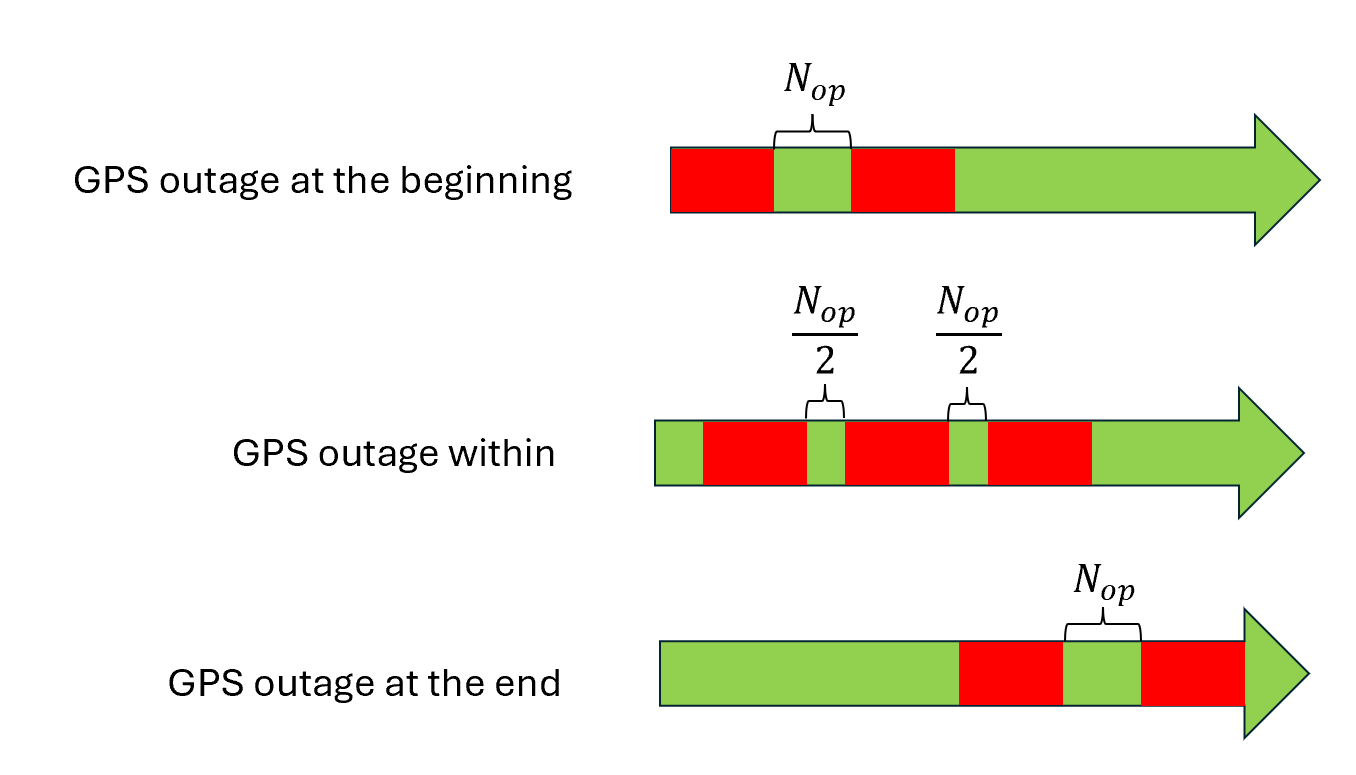

In [35]:
N_MINIMUM_SECONDS_OPERATIONAL_GPS = 4

- <u>**GPS outage duration eval at beginning**</u>
    - A list of tuple following the format ("MM:SS", "MM:SS")
    - Default = <code>[]</code>

After training the neural networks on your data, the framework will evaluate their accuracy using the evaluation dataset.

This parameter controls the ranges of GPS outage durations for **beginning cases** (i.e., GPS outages that occur starting from the very first recorded sample) on which the networks will be evaluated. The format is a list of tuples: <code>("MM:SS", "MM:SS")</code>, representing GPS outages lasting from MM minutes and SS seconds to MM minutes and SS seconds.

These ranges should align with your specific needs, particularly the characteristics of GPS outages observed during normal sensor usage. It is recommended to segment the overall duration into multiple ranges to better understand the model's accuracy across different outage lengths.

In [36]:
GPS_OUTAGE_DURATIONS_EVAL_AT_BEGINNING = [("00:10", "00:30"), ("00:30", "01:00"), ("01:00", "02:00"), ("02:00", "04:00")]

- <u>**GPS outage duration eval within**</u>
    - A list of tuple following the format ("MM:SS", "MM:SS")
    - Default = <code>[]</code>

After training the neural networks on your data, the framework will evaluate their accuracy using the evaluation dataset.

This parameter controls the ranges of GPS outage durations for **within cases** (i.e., GPS outages that occur neither starting at the very first sample nor ending at the very last sample) on which the networks will be evaluated. The format is a list of tuples: <code>("MM:SS", "MM:SS")</code>, representing GPS outages lasting from MM minutes and SS seconds to MM minutes and SS seconds.

These ranges should align with your specific needs, particularly the characteristics of GPS outages observed during normal sensor usage. It is recommended to segment the overall duration into multiple ranges to better understand the model's accuracy across different outage lengths.

In [37]:
GPS_OUTAGE_DURATIONS_EVAL_WITHIN = [("00:30", "01:00"), ("01:00", "02:00"), ("02:00", "04:00"), ("04:00", "10:00")]

- <u>**GPS outage duration eval at end**</u>
    - A list of tuple following the format ("MM:SS", "MM:SS")
    - Default = <code>[]</code>

After training the neural networks on your data, the framework will evaluate their accuracy using the evaluation dataset.

This parameter controls the ranges of GPS outage durations for **end cases** (i.e., GPS outages that occur ending at the very last recorded sample) on which the networks will be evaluated. The format is a list of tuples: <code>("MM:SS", "MM:SS")</code>, representing GPS outages lasting from MM minutes and SS seconds to MM minutes and SS seconds.

These ranges should align with your specific needs, particularly the characteristics of GPS outages observed during normal sensor usage. It is recommended to segment the overall duration into multiple ranges to better understand the model's accuracy across different outage lengths.

In [38]:
GPS_OUTAGE_DURATIONS_EVAL_AT_END = [("00:10", "00:25"), ("00:30", "01:00")]

#### 5.1.6. Training settings

- <u>**Coeff sampling training**</u>
    - Strictly positive integer
    - Default = <code>10000</code>

When neural networks are trained, they sequentially receive windows of data containing simulated GPS outages. Not every sample in each session is considered as a starting point for a window. Using every sample would generate nearly identical windows, which would provide minimal additional information to the neural networks while significantly increasing training time.

The sampling coefficient for training controls the number of samples between the starting points of two consecutive windows.

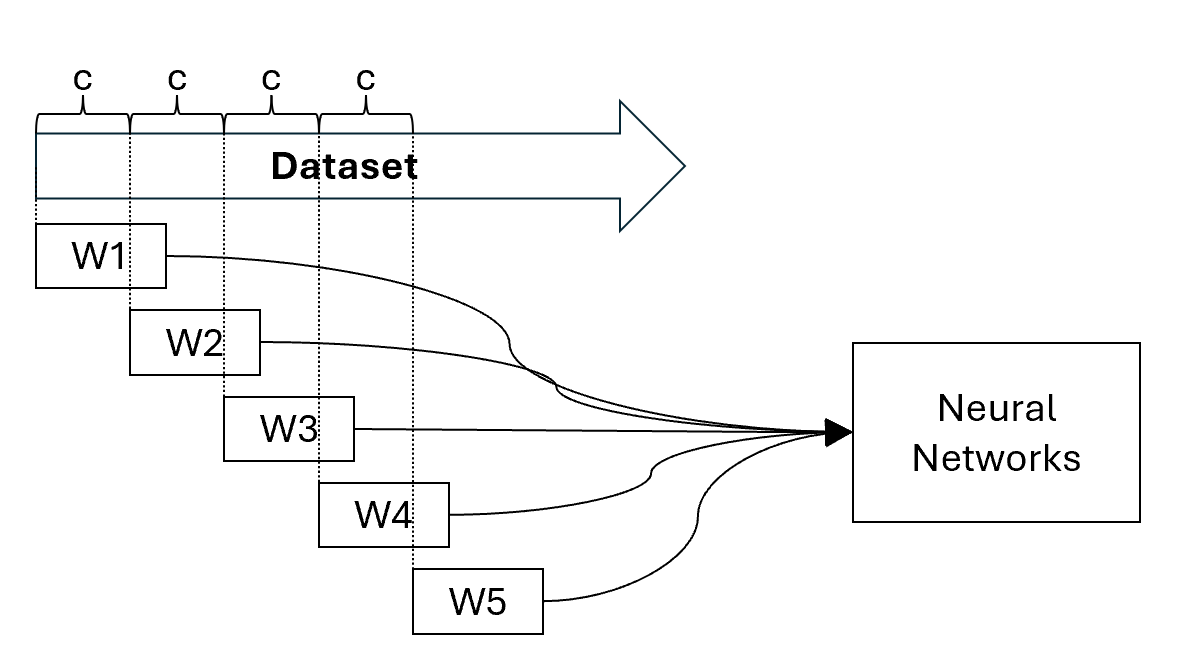

Setting this value too high can lead to poor performance, while setting it too low can result in slow training and, if excessively low, potentially suboptimal results. The appropriate value depends on your dataset size, sensor frequency, and the duration of GPS outages you're targeting. You must define a value that is suitable for your specific configuration. Here’s how each parameter influences the choice of the sampling coefficient:

- Dataset size: The smaller your dataset, the lower the coefficient should be. A small coefficient allows for denser window sampling, helping compensate for limited data. If your dataset is large enough, you can increase the coefficient to avoid spending time training on nearly identical windows.

- Sensor frequency: This affects the coefficient because the number of samples defines a duration. The time between two windows is equal to the coefficient divided by the frequency.

- Target GPS outage durations: These also play a key role, especially the maximum duration. If you're focusing on short outages, the input windows will be small, allowing you to use a smaller coefficient while still maintaining varied windows. For longer outages, the windows are larger, and you must increase the coefficient to prevent excessive overlap and redundancy.

Baseline example: The POSNNET framework was developed using a dataset of 76 hours, targeting GPS outages ranging from 10 seconds to 5 minutes, with a sensor frequency of 100 Hz. A coefficient value of 10,000 was used and produced good results. In other words, 5-minute windows were extracted every 100 seconds for each session.

In [39]:
COEFF_SAMPLING_TRAINING = 10000

- <u>**Coeff sampling validation**</u>
    - Strictly positive integer
    - Default = <code>2000</code>

The sampling coefficient for validation follows the same principle as the one used for training. While a coefficient that is too high can lead to poorly representative tuning results, a coefficient that is too low will only slow down the validation process—there is no risk of suboptimal results due to excessive redundancy during validation.

It is recommended to use one-fifth of the sampling coefficient used for training.

In [40]:
COEFF_SAMPLING_VALIDATION = 2000

- <u>**N epochs**</u>
    - Striclty positive integer
    - Default = <code>100</code>

This parameter controls the maximum number of epochs for which the neural networks will be trained. Note that the framework includes an early stopping mechanism (see *patience* setting), so training may stop before reaching this number if no improvement is detected. The higher this value, the longer the training time—assuming improvements are still being made. Setting this value too high can lead to unnecessarily long training, while setting it too low may cause training to stop prematurely, potentially missing better configurations.

Some recommendations:

- In general, it is recommended to use <code>100</code> epochs.  
- If you want to save some time, you can use <code>50</code> epochs, though this may result in slightly suboptimal outcomes.  
- To save even more time, you can use between <code>20</code> and <code>30</code> epochs, but this carries a higher risk of poor results.  
- If you have ample time and want to maximize accuracy, you can use <code>200</code> epochs.

In [41]:
N_EPOCHS = 100

- <u>**Patience**</u>
    - Strictly positive integer or <code>None</code>
    - Default = <code>10</code>

At the end of every training epoch, the neural networks are evaluated on the validation dataset. The *patience* parameter controls the number of consecutive epochs without improvement before stopping the training early (early stopping). This mechanism helps prevent spending unnecessary time when the models have already reached their optimal performance.

If you set <code>None</code>, early stopping is disabled, and each neural network will be trained for the full number of epochs specified by the *N epochs* parameter. The higher the patience value, the longer the framework will continue training despite no improvement.

Setting the value too high may result in wasted time training models that have already achieved their best results, while setting it too low may prematurely stop training on configurations that could improve with more epochs.

Some recommendations:

- Generally, a patience value of <code>10</code> epochs is recommended.  
- To save time, you can use <code>8</code> epochs, with a slight risk of suboptimal results.  
- For even faster training, you can reduce it to <code>5</code> epochs, though this increases the risk of poor performance.  
- If you have plenty of time and want to maximize accuracy, you can use <code>20</code> epochs.

In [42]:
PATIENCE = 10

- <u>**N epochs sampling**</u>
    - Strictly positive integer
    - Default = <code>20</code>

During training and validation, not every sample in each session is used as a starting point for a window. This behavior is controlled by the *sampling coefficient for training* and the *sampling coefficient for validation*. 

For validation, the same samples are used at each epoch to ensure consistent validation results. In contrast, for training, the set of samples changes with each epoch to improve data diversity.

The *number of epochs for sampling* controls how often the sampling cycle resets. It defines how many epochs occur before restarting the sampling pattern from the beginning. The higher the number of epochs, the smaller the offset added at each epoch. 

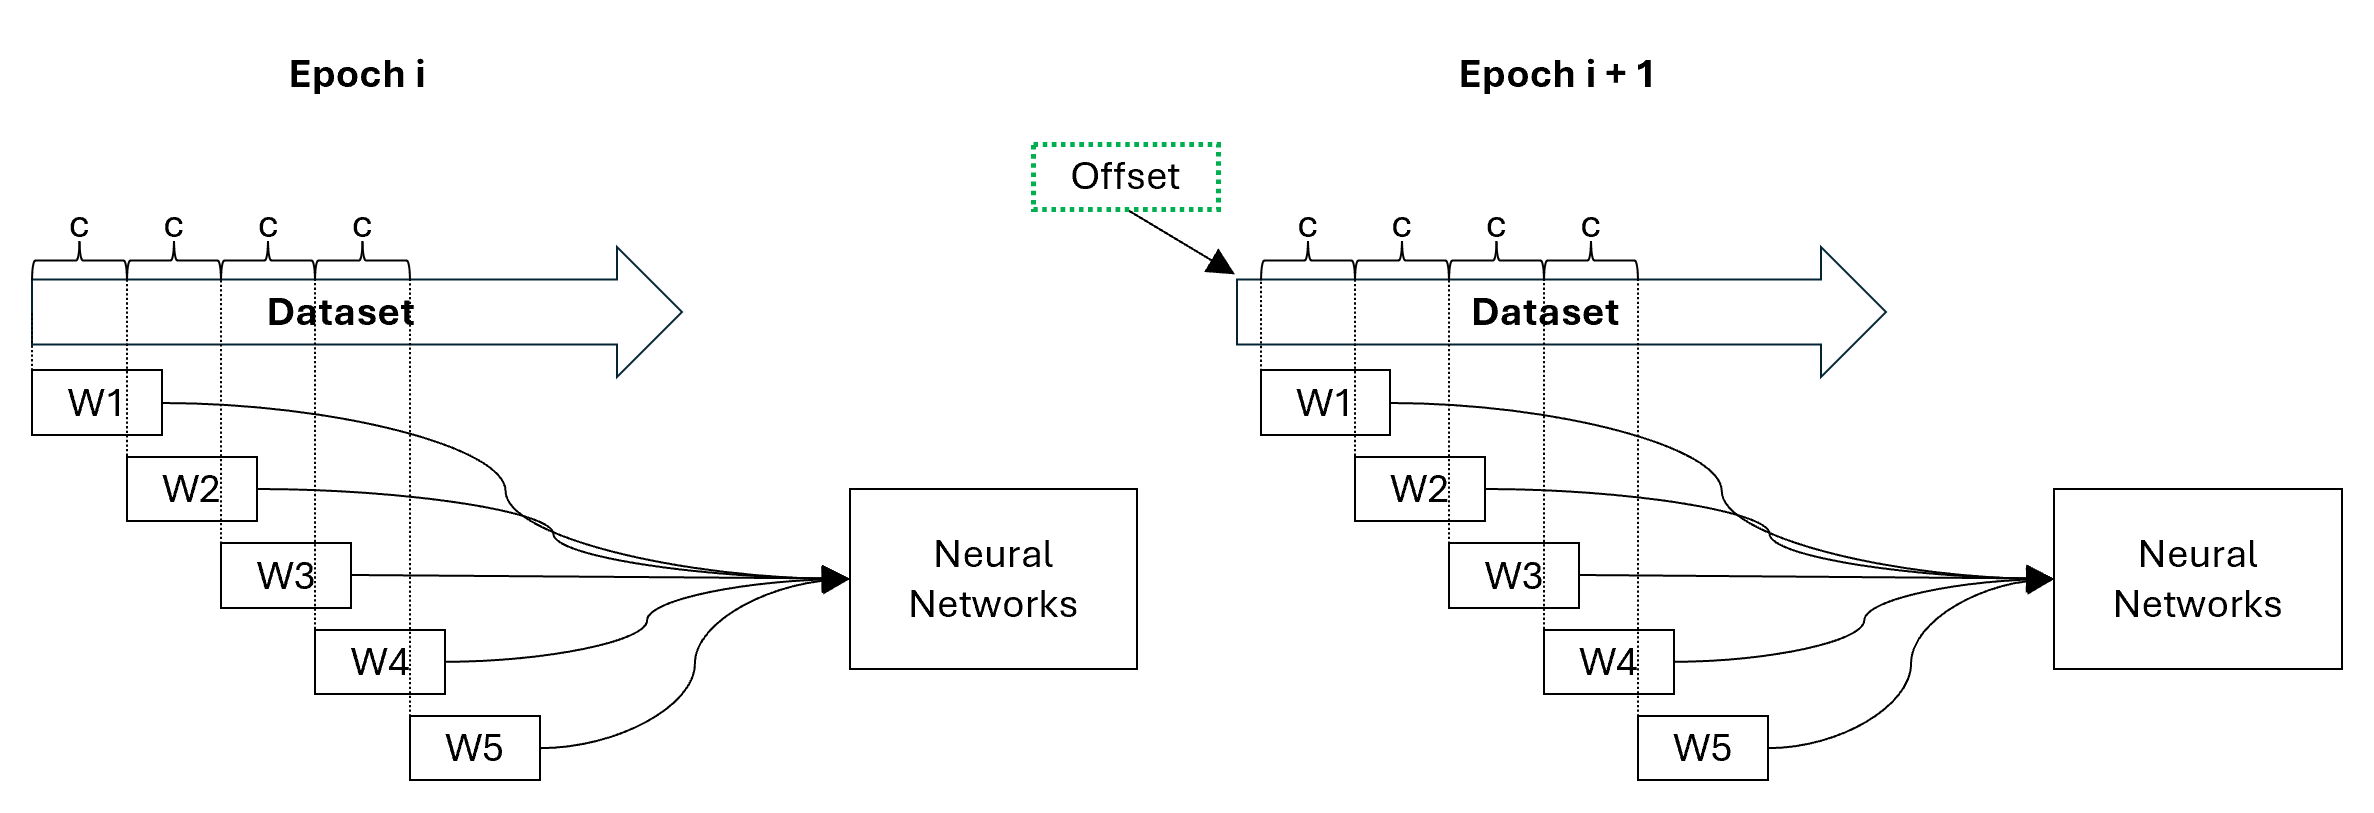

General guidelines:

- Aim for a number of epochs for sampling around to one-fifth of the maximum number of epochs.  
- It is recommended to use at least <code>10</code> epochs for sampling.

In [43]:
N_EPOCHS_SAMPLING = 20

- <u>**Velocity loss**</u>
    - Either <code>'mae'</code> or <code>'mse'</code>
    - Default = <code>'mse'</code>

The velocity loss function is used to optimize the neural networks:

- <code>'mae'</code> for Mean Absolute Error (MAE): MAE penalizes errors linearly. An error of value *a × e* will be penalized *a* times more than an error of value *e*. In other words, the model will aim to reduce all errors equally.

- <code>'mse'</code> for Mean Squared Error (MSE): MSE penalizes errors quadratically. An error of value *a × e* will be penalized *a²* times more than an error of value *e*. In other words, the model will focus more on reducing large errors.

Your choice affects the neural networks' training objective and should align with your goals:

- If you don't mind occasional large errors and want all errors to be treated equally, use <code>'mae'</code>.
- If you want to avoid large errors, even if it means slightly higher average errors, consider <code>'mse'</code>.

To help you decide, consider the example you prefer:

- “My system can reconstruct the trajectory with an average error of 2 meters, with occasional errors of up to 10 meters.” → Choose <code>'mae'</code>
- “My system can reconstruct the trajectory with an average error of 3 meters, with occasional errors of up to 5 meters.” → Choose <code>'mse'</code>


If you're unsure, it is recommended to use <code>'mse'</code>. In most business applications, it's preferable to minimize extreme errors, even if it comes at the cost of slightly higher average errors. It's usually better to be consistently accurate than to perform well 99% of the time but produce significant errors 1% of the time.


In [44]:
VELOCITY_LOSS = 'mse'

- <u>**Use mixed precision**</u>
    - Boolean
    - Default = <code>True</code>

Defines whether mixed precision training is activated or not. Mixed precision training automatically determines the lowest variable precision suitable for operations, typically resulting in faster training and reduced memory consumption. While it may slightly reduce final accuracy, the difference is usually negligible.

It is recommended to set this to <code>True</code> unless you have a specific reason to disable mixed precision training.

In [45]:
USE_MIXED_PRECISION = True

- <u>**Num workers**</u>
    - Positive integer
    - Default = <code>0</c

The number of processes used to load data during training and inference. If set to <code>0</code>, the data will be loaded by the main process. 

A common rule of thumb is to set the number of workers to 4 times the number of GPUs used. If you're not familiar with software engineering, it's recommended to stick with <code>0</code>.

In [46]:
NUM_WORKERS = 0

- <u>**N epochs training checkpoint**</u>
    - Strictly positive integer
    - Default = <code>10</code>

Training neural networks can be time-consuming, depending on your computing system, the amount of data, and the GPS outage durations you're targeting. During training, checkpoints are saved periodically so that training can be resumed from the last checkpoint if it is interrupted.

While saving checkpoints is useful, doing so too frequently can slow down the training process, so there’s a trade-off:

- If you're confident that training will never (or only rarely) be interrupted, set the number of checkpoints equal to the total number of epochs (effectively disabling checkpointing).

- If training may be occasionally interrupted, choose a value between <code>10</code> and <code>20</code>.

- If interruptions are likely to occur more frequently, choose a value between <code>3</code> and <code>10</code>.

This helps balance reliability with training efficiency.

In [47]:
N_EPOCHS_TRAINING_CHECKPOINT = 10

#### 5.1.7. Tuning settings

- <u>**N startup trials**</u>
    - Strictly positive integer
    - Default = <code>10</code>

For every model architecture, several combinations of hyperparameters will be tested in a stage called tuning. To perform this, the POSNNET framework uses Bayesian optimization to select which combinations to try. Before the Bayesian optimization begins, some combinations are selected at random. The *number of startup trials* parameter controls how many combinations are randomly sampled before Bayesian optimization starts.

As a rule of thumb, you can set this parameter to 1/10 to 1/5 of the total number of trials you plan to run for each model architecture. If you're unsure, it is recommended to set this parameter to <code>10</code>. It is also recommended not to decrease it below <code>8</code>.

In [48]:
N_STARTUP_TRIALS = 10

- <u>**Save every state dicts**</u>
    - Boolean
    - Default = <code>False</code>

Defines whether the state dictionaries of all models tested during the tuning stage are saved (<code>True</code>) or only the best one (<code>False</code>). Saving all state dictionaries can be useful for debugging or for developers with specific needs, but in most cases, it is unnecessary. It is recommended to set this parameter to <code>False</code>.

Note: Saving every state dictionary can consume a significant amount of disk space (up to hundreds of GB).

In [49]:
SAVE_EVERY_STATE_DICTS = False

### 5.2. Modify the settings

This section presents how to modify the settings of a POSNNET project:

[5.2.1. Project methods](#5.2.1.-Project-methods)  
[5.2.2. Partial modification](#5.2.2.-Partial-modification)  
[5.2.3. Incorrect values](#5.2.3.-Incorrect-values)

#### 5.2.1. Project methods

To modify the settings of your POSNNET project, you have access to seven different methods, one for each category of settings.

**General settings**

In [50]:
project.set_general_settings(
    random_seed=RANDOM_SEED,
    dtype=DTYPE,
    device=DEVICE
)

**CSV files settings**

In [51]:
project.set_csv_files_settings(
    csv_sep=CSV_SEP,
    csv_encoding=CSV_ENCODING
)

**Sensor settings**

In [52]:
project.set_sensor_settings(
    frequency=FREQUENCY,
    name_accelerometer_x=NAME_ACCELEROMETER_X,
    name_accelerometer_y=NAME_ACCELEROMETER_Y,
    name_accelerometer_z=NAME_ACCELEROMETER_Z,
    name_gyroscope_x=NAME_GYROSCOPE_X,
    name_gyroscope_y=NAME_GYROSCOPE_Y,
    name_gyroscope_z=NAME_GYROSCOPE_Z,
    name_magnetometer_x=NAME_MAGNETOMETER_X,
    name_magnetometer_y=NAME_MAGNETOMETER_Y,
    name_magnetometer_z=NAME_MAGNETOMETER_Z,
    name_velocity_gps_x=NAME_VELOCITY_GPS_X,
    name_velocity_gps_y=NAME_VELOCITY_GPS_Y,
    name_velocity_gps_z=NAME_VELOCITY_GPS_Z,
    name_position_fusion_x=NAME_POSITION_FUSION_X,
    name_position_fusion_y=NAME_POSITION_FUSION_Y,
    name_position_fusion_z=NAME_POSITION_FUSION_Z,
    name_velocity_fusion_x=NAME_VELOCITY_FUSION_X,
    name_velocity_fusion_y=NAME_VELOCITY_FUSION_Y,
    name_velocity_fusion_z=NAME_VELOCITY_FUSION_Z,
    name_orientation_fusion_x=NAME_ORIENTATION_FUSION_X,
    name_orientation_fusion_y=NAME_ORIENTATION_FUSION_Y,
    name_orientation_fusion_z=NAME_ORIENTATION_FUSION_Z
)

**Dataset settings**

In [53]:
project.set_dataset_settings(
    n_duplications_per_eval_session=N_DUPLICATIONS_PER_EVAL_SESSION,
    sessions_id_training=SESSIONS_ID_TRAINING,
    sessions_id_validation=SESSIONS_ID_VALIDATION,
    sessions_id_evaluation=SESSIONS_ID_EVALUATION
)

**Objective settings**

In [54]:
project.set_objective_settings(
    n_minimum_seconds_operational_gps=N_MINIMUM_SECONDS_OPERATIONAL_GPS,
    gps_outage_durations_eval_at_beginning=GPS_OUTAGE_DURATIONS_EVAL_AT_BEGINNING,
    gps_outage_durations_eval_within=GPS_OUTAGE_DURATIONS_EVAL_WITHIN,
    gps_outage_durations_eval_at_end=GPS_OUTAGE_DURATIONS_EVAL_AT_END
)

**Training settings**

In [55]:
project.set_training_settings(
    coeff_sampling_training=COEFF_SAMPLING_TRAINING,
    coeff_sampling_validation=COEFF_SAMPLING_VALIDATION,
    n_epochs_sampling=N_EPOCHS_SAMPLING,
    n_epochs=N_EPOCHS,
    patience=PATIENCE,
    num_workers=NUM_WORKERS,
    use_mixed_precision=USE_MIXED_PRECISION,
    n_epochs_training_checkpoint=N_EPOCHS_TRAINING_CHECKPOINT
)

**Tuning settings**

In [56]:
project.set_tuning_settings(
    n_startup_trials=N_STARTUP_TRIALS,
    save_every_state_dicts=SAVE_EVERY_STATE_DICTS
)

#### 5.2.2. Partial modification

When modifying a category of settings, you do not need to provide all the settings—only the ones you want to change. Any settings you do not provide will remain unchanged.

In [57]:
# Full call, modify every general setting.
project.set_general_settings(
    random_seed=RANDOM_SEED,
    dtype=DTYPE,
    device=DEVICE
)

# Modify only dtype setting.
project.set_general_settings(
    dtype=DTYPE
)

#### 5.2.3. Incorrect values

If you provide a value that is not accepted for a setting, you will receive a notification and that specific setting will not be modified. However, if you provide multiple settings and some of them are valid, only the valid ones will be updated.

In [58]:
# Random seed is not updated.
project.set_general_settings(
    random_seed=-1
)

 - The parameter 'random_seed' should be a positive integer (0 included) but you provided the value -1. The value of the parameter has been ignored. The actual value is 42.



In [59]:
# Random seed and dtype are not updated but device is updated.
project.set_general_settings(
    random_seed=-1,
    dtype='my_dtype',
    device='auto'
)

 - The parameter 'random_seed' should be a positive integer (0 included) but you provided the value -1. The value of the parameter has been ignored. The actual value is 42.

 - The parameter 'dtype' has to be one of the available choices (['float16', 'float32', 'float64']) but you provided the value my_dtype. The value of the parameter has been ignored. The actual value is float32.



### 5.3. Display the settings

To display the settings of your POSNNET project, you have access to seven different methods, one for each category of settings.

**General settings**

In [60]:
project.print_general_settings()

The parameter 'random_seed' is set to 42
The parameter 'dtype' is set to float32
The parameter 'device' is set to cuda


**CSV files settings**

In [61]:
project.print_csv_files_settings()

The parameter 'csv_sep' is set to ,
The parameter 'csv_encoding' is set to utf-8


**Sensor settings**

In [62]:
project.print_sensor_settings()

The parameter 'frequency' is set to 100
The parameter 'name_accelerometer_x' is set to accelerometer_x
The parameter 'name_accelerometer_y' is set to accelerometer_y
The parameter 'name_accelerometer_z' is set to accelerometer_z
The parameter 'name_gyroscope_x' is set to gyroscope_x
The parameter 'name_gyroscope_y' is set to gyroscope_y
The parameter 'name_gyroscope_z' is set to gyroscope_z
The parameter 'name_magnetometer_x' is set to magnetometer_x
The parameter 'name_magnetometer_y' is set to magnetometer_y
The parameter 'name_magnetometer_z' is set to magnetometer_z
The parameter 'name_velocity_gps_x' is set to velocity_gps_x
The parameter 'name_velocity_gps_y' is set to velocity_gps_y
The parameter 'name_velocity_gps_z' is set to velocity_gps_z
The parameter 'name_position_fusion_x' is set to position_fusion_x
The parameter 'name_position_fusion_y' is set to position_fusion_y
The parameter 'name_position_fusion_z' is set to position_fusion_z
The parameter 'name_velocity_fusion_x' 

**Dataset settings**

In [63]:
project.print_dataset_settings()

The parameter 'n_duplications_per_eval_session' is set to normal
The parameter 'sessions_id_training' is set to [3, 5, 8, 9, 12, 14, 16, 25, 29, 34, 45, 74, 103]
The parameter 'sessions_id_validation' is set to [4, 7, 44, 55]
The parameter 'sessions_id_evaluation' is set to [1, 13, 28, 65]


**Objective settings**

In [64]:
project.print_objective_settings()

The parameter 'n_minimum_seconds_operational_gps' is set to 4
The parameter 'gps_outage_durations_eval_at_beginning' is set to [('00:10', '00:30'), ('00:30', '01:00'), ('01:00', '02:00'), ('02:00', '04:00')]
The parameter 'gps_outage_durations_eval_within' is set to [('00:30', '01:00'), ('01:00', '02:00'), ('02:00', '04:00'), ('04:00', '10:00')]
The parameter 'gps_outage_durations_eval_at_end' is set to [('00:10', '00:25'), ('00:30', '01:00')]


**Training settings**

In [65]:
project.print_training_settings()

The parameter 'coeff_sampling_training' is set to 10000
The parameter 'coeff_sampling_validation' is set to 2000
The parameter 'n_epochs_sampling' is set to 20
The parameter 'n_epochs' is set to 100
The parameter 'patience' is set to 10
The parameter 'num_workers' is set to 0
The parameter 'use_mixed_precision' is set to True
The parameter 'n_epochs_training_checkpoint' is set to 10
The parameter 'velocity_loss' is set to mse


**Tuning settings**

In [66]:
project.print_tuning_settings()

The parameter 'n_startup_trials' is set to 10
The parameter 'save_every_state_dicts' is set to False


### 5.4. Validate the settings

When you have finished configuring the settings for your POSNNET project, you must validate them. To do this, use the method <code>Project.validate_settings</code>.

There are three possible outcomes:

[5.4.1. The method returns error(s) (with or without warning(s))](#5.4.1.-The-method-returns-error(s)-(with-or-without-warning(s)))  
[5.4.2. The method returns warning(s) but no error](#5.4.2.-The-method-returns-warning(s)-but-no-error)  
[5.4.3. The settings are successfully validated without errors or warnings](#5.4.3.-The-settings-are-successfully-validated-without-errors-or-warnings)

#### 5.4.1. The method returns error(s) (with or without warning(s))

In [67]:
# For the purpose of the user guide, let generate an error by providing an empty training dataset.
project.set_dataset_settings(
    sessions_id_training=[]
)

# The validation method return an error.
project.validate_settings()

You have actually 1 error(s) inside your settings. The settings cannot be validated. Please correct the errors and call again the validation settings method.


Errors in the settings:
	 E1: You do not have provided any session for the training dataset.



In this case, you need to modify your settings to correct the error(s). Once corrected, call the method again.

In [68]:
# Correct the error.
project.set_dataset_settings(
    sessions_id_training=SESSIONS_ID_TRAINING
)

# Now the validation method successfully validates the settings.
project.validate_settings()

The project settings have been validated.


If you have no warning(s), you can proceed to the next stage. Otherwise, please refer to Section 5.4.2: *The method returns warning(s) but no error*.

#### 5.4.2. The method returns warning(s) but no error

In [70]:
# For the purpose of the user guide, let generate a warning by providing the device 'cpu'
project.set_general_settings(
    device='cpu'
)

# The validation method return a warning.
project.validate_settings()

You have actually 1 warning(s) inside your settings. You can either change your settings or you can call again the validation settings method with the argument 'force_validation=True'.


Warnings in the settings:
	 W1: You selected the device 'cpu' for training and inference. Due to this choice, the training and inference will be performed on your CPU even if your system has a CUDA compatible GPU, resulting in significant higher computation time. If you are not sure about your system having a CUDA compatible GPU or not, it is recommended to select the mode 'auto' to let the framework determine if CUDA is available. Ignore this message if you are sure to use the CPU.



In this case, you have two options. The first option is to modify your settings to address the warning.

In [71]:
# Correct the warning
project.set_general_settings(
    device=DEVICE
)

# Now the validation method successfully validates the settings.
project.validate_settings()

The project settings have been validated.


The second option is to keep your current settings and force the validation.

In [73]:
# For the purpose of the user guide, let generate a warning by providing the device 'cpu'
project.set_general_settings(
    device='cpu'
)

# Now the validation method successfully validates the settings.
project.validate_settings(force_validation=True)

The project settings have been validated.


Warnings in the settings:
	 W1: You selected the device 'cpu' for training and inference. Due to this choice, the training and inference will be performed on your CPU even if your system has a CUDA compatible GPU, resulting in significant higher computation time. If you are not sure about your system having a CUDA compatible GPU or not, it is recommended to select the mode 'auto' to let the framework determine if CUDA is available. Ignore this message if you are sure to use the CPU.



You can proceed to the next stage.

#### 5.4.3. The settings are successfully validated without errors or warnings

In [75]:
project.validate_settings()

The project settings have been validated.


You can proceed to the next stage.

## 6. Preprocess your data

After validating your POSNNET project settings, the project enters the **Data preprocessing stage**. You can now begin preprocessing your data using the method <code>Project.preprocess_data</code>. 

Use the argument <code>verbosity=True</code> if you want to see detailed progress during preprocessing. At the end of the process, you will receive a report summarizing the number of GPS outages simulated for each case.

In [76]:
project.preprocess_data(verbosity=True)

Preprocessing of the training data: 100.00%
Preprocessing of the validation data: 100.00%
Loading of the evaluation data: 100.00%
GPS outage simulation for case 'beginning' from 00-10 to 00-30: 100.00%
GPS outage simulation for case 'beginning' from 00-30 to 01-00: 100.00%
GPS outage simulation for case 'beginning' from 01-00 to 02-00: 100.00%
GPS outage simulation for case 'beginning' from 02-00 to 04-00: 100.00%
GPS outage simulation for case 'within' from 00-30 to 01-00: 100.00%
GPS outage simulation for case 'within' from 01-00 to 02-00: 100.00%
GPS outage simulation for case 'within' from 02-00 to 04-00: 100.00%
GPS outage simulation for case 'within' from 04-00 to 10-00: 100.00%
GPS outage simulation for case 'end' from 00-10 to 00-25: 100.00%
GPS outage simulation for case 'end' from 00-30 to 01-00: 100.00%
****************************************************************************************************
********************************************** REPORT *******************

If you have specified GPS outage durations that are longer than the duration of the sessions in the evaluation dataset, the framework will not be able to simulate GPS outages for those cases. In such instances, you will receive a warning report informing you of the cases that could not be processed.

If you want to modify these settings, please see section [11. Revert to a previous stage](#11.-Revert-to-a-previous-stage) to come back to the settings definition stage. Otherwise, this case will be ignored.

In [78]:
# For the purpose of this user guide, a GPS outage duration for the case `'within'` ranging from 59 minutes to 59 minutes and 59 seconds 
# has been added to the objective. Since no session is long enough to simulate such a GPS outage, 
# the framework will not process this case and will generate a warning report.

project.preprocess_data(verbosity=True)

Preprocessing of the training data: 100.00%
Preprocessing of the validation data: 100.00%
Loading of the evaluation data: 100.00%
GPS outage simulation for case 'beginning' from 00-10 to 00-30: 100.00%
GPS outage simulation for case 'beginning' from 00-30 to 01-00: 100.00%
GPS outage simulation for case 'beginning' from 01-00 to 02-00: 100.00%
GPS outage simulation for case 'beginning' from 02-00 to 04-00: 100.00%
GPS outage simulation for case 'within' from 00-30 to 01-00: 100.00%
GPS outage simulation for case 'within' from 01-00 to 02-00: 100.00%
GPS outage simulation for case 'within' from 02-00 to 04-00: 100.00%
GPS outage simulation for case 'within' from 04-00 to 10-00: 100.00%
GPS outage simulation for case 'within' from 59-00 to 59-59: 100.00%
GPS outage simulation for case 'end' from 00-10 to 00-25: 100.00%
GPS outage simulation for case 'end' from 00-30 to 01-00: 100.00%
****************************************************************************************************
****

## 7. Fit the scalers

Now that you have preprocessed your data, the project has moved to the **Scalers fitting stage**. You can proceed to fit the scalers using the method <code>Project.fit_scalers</code>.

In [80]:
project.fit_scalers()

## 8. Tune and evaluate the neural networks

After fitting the scalers, the project enters the **Models tuning stage**. It is finally time to proceed with the tuning and evaluation of the neural networks.

[8.1. Project methods](#8.1.-Project-methods)  
[8.2. Tuning/Evaluation flow](#8.2.-Tuning/Evaluation-flow)  
[8.3. Configurations choice](#8.3.-Configurations-choice)  
[8.4. Validate models tuning](#8.4.-Validate-models-tuning)

### 8.1. Project methods

This section presents the different <code>Project</code> methods used to perform the tuning and evaluation of the neural networks.

[8.1.1. Tuning](#8.1.1.-Tuning)  
[8.1.2. Evaluation](#8.1.2.-Evaluation)  
[8.1.3 Results dashboard](#8.1.3.-Results-dashboard)  

#### 8.1.1. Tuning

To perform the tuning of a neural network architecture, use the method <code>Project.run_tuning</code>.

For configurations choice, please refer to the part [8.3. Configurations choice](#8.3.-Configurations-choice)

This method takes several arguments:

- <code>n_experiments</code>: The number of hyperparameter sets (i.e., different combinations) that will be tried for the specified architecture. A higher number increases the chances of finding an optimal combination but also increases the tuning time.
    - If you have a basic computing system or limited time, consider a value between <code>15</code> and <code>30</code>. There is a chance the framework may not find a suitable combination.
    - A recommended value is <code>50</code>.
    - If you have a powerful computing system and/or plenty of time, you can go up to <code>100</code> to maximize accuracy.<br><br>

- <code>model_name</code>: The name of the neural network architecture to tune. Options include:
    - <code>'CLSTMTWB'</code>: Convolutional Long Short-Term Memory With Bypass  
    - <code>'CLSTMTFAWB'</code>: Convolutional Long Short-Term Memory Frequency Aware With Bypass  
    - <code>'STTWB'</code>: Spatio-Temporal Transformer With Bypass  
    - <code>'STTFAWB'</code>: Spatio-Temporal Transformer Frequency Aware With Bypass  
    - <code>'TCANWB'</code>: Temporal Convolutional Attentive Network With Bypass  <br><br>

- <code>use_adversarial</code>: Determines whether adversarial examples are used during training:
    - <code>None</code>: No adversarial examples  
    - <code>'imu'</code>: Apply adversarial examples to IMU data only  
    - <code>'full'</code>: Apply adversarial examples to all input data  <br><br>

- <code>training_type</code>: Determines where the GPS outage will be simulated during training:
    - <code>'beginning'</code>: Outages at the beginning of the sequence; network will handle only beginning outages in production  
    - <code>'centered'</code>: Outages within the sequence; network will handle only inside-session outages  
    - <code>'end'</code>: Outages at the end of the sequence; network will handle only end-of-session outages  
    - <code>'random'</code>: Outages at random positions; network can handle outages at any point in the session  <br><br>

- <code>coeff_frequency_division</code>: Controls the factor by which the input frequency is divided before feeding the network. 
    - <code>1</code> = no division.  
    - A value > <code>1</code> reduces the number of samples and thus memory and time consumption. 
    - Frequency reduction may slightly reduce accuracy, but this is often compensated by being able to try more combinations or use deeper architectures.  <br><br>

    *To choose a suitable value*, calculate:  
    (minimal number seconds of operational GPS + max GPS outage duration in seconds) × sensor frequency = total input samples  
    Use this value to determine if frequency division is needed:
    - *Basic system (old GPU or CPU only)*: target 300–800 samples  
    - *Moderate system (standard GPU)*: target 1000–2000 samples  
    - *High-end system (latest-gen GPU)*: target 3000–5000 samples  

    *Note:* During the development of POSNNET, a coefficient of <code>10</code> was used with excellent results and no accuracy loss. If unsure, use <code>10</code>.

- <code>gps_outage_duration</code>: The minimum and maximum duration of GPS outages the network should be trained to handle. Format: <code>("MM:SS", "MM:SS")</code>.

- <code>verbosity</code>: Controls how much information is displayed during tuning (for information only, does not affect tuning):
    - <code>0</code>: No output  
    - <code>1</code>: Display results of each combination  
    - <code>2</code>: Display intermediate results after each epoch (generates a large amount of output)  


In [84]:
# NB : For the purpose of the demonstration, the number of epochs in the settings have been set to 1 (instead of 100). 
# Also, only one trial is experimented instead of 100.

project.run_tuning(
    n_experiments=1, # 100
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

project.run_tuning(
    n_experiments=1, # 100
    model_name="CLSTMTWB",
    use_adversarial="imu",
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

project.run_tuning(
    n_experiments=1, # 100
    model_name="STTWB",
    use_adversarial="full",
    training_type="random",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

#### 8.1.2. Evaluation

After tuning a configuration, you can evaluate it to obtain representative performance scores as they would appear in a production setting. To do this, use the method <code>Project.evaluate_configuration</code>.

This method takes several arguments:

- <code>model_name</code>: The name of the neural network architecture to evaluate.
- <code>use_adversarial</code>: Determines whether adversarial examples are used during training.
- <code>training_type</code>: Determines where the GPS outage will be simulated during training.
- <code>coeff_frequency_division</code>: Controls the factor by which the input frequency is divided before feeding the network.
- <code>gps_outage_duration</code>: The minimum and maximum duration of GPS outages the network should be trained to handle. Format: <code>("MM:SS", "MM:SS")</code>.
- <code>verbosity</code>: Either to print progress or not.

In [85]:
project.evaluate_configuration(
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

project.evaluate_configuration(
    model_name="CLSTMTWB",
    use_adversarial="imu",
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

project.evaluate_configuration(
    model_name="STTWB",
    use_adversarial="full",
    training_type="random",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

Case within from 00-30 to 01-00 progress: 100.00%
Case within from 01-00 to 02-00 progress: 100.00%
Case within from 00-30 to 01-00 progress: 100.00%
Case within from 01-00 to 02-00 progress: 100.00%
Case beginning from 00-30 to 01-00 progress: 100.00%
Case beginning from 01-00 to 02-00 progress: 100.00%
Case within from 00-30 to 01-00 progress: 100.00%
Case within from 01-00 to 02-00 progress: 100.00%
Case end from 00-30 to 01-00 progress: 100.00%


#### 8.1.3. Results dashboard

The framework presents tuning and evaluation results through a dashboard that you can access with the method <code>project.display_dashboard</code>.

For each configuration, the dashboard provides two tuning-related metrics:

- **Velocity loss**  
  The value of the loss function (either MAE or MSE, depending on your project settings) during validation.  
  *Note: This value is computed on scaled data and cannot be interpreted directly in m/s.*

- **ATE (in m)**  
  Average Trajectory Error—the mean Euclidean distance between ground-truth and reconstructed positions.
    
For each configuration, the dashboard provides two evaluation-related metrics:

- **AVE (in m/s)**  
  Average Velocity Error—the mean Euclidean norm of the difference between ground-truth and reconstructed velocities.  
  *Interpretation:* “The configuration reconstructed velocity with an average error of **x m/s**.”

- **RMVE (%)**  
  Relative Maximum Velocity Error—the maximum Eucliean norm of the difference between ground-truth and reconstructed velocities, divided by the AVE.  
  *Interpretation:* “The maximum velocity error is *x %* of the AVE.”  
  A value of 100 % means the maximum error equals the average error.  
  Maximum velocity error = <code>(RMVE / 100) × AVE m/s</code>.  
  *E.g. If the AVE is 1 m/s and the RMVE is 150%, the maximum velocity error is 1.5 m/s*  

- **STDVE (in m/s)**  
  Standard Deviation of the Velocity Error—the standard deviation of the Euclidean norm of the difference between ground-truth and reconstructed velocities.
  It quantifies if the errors are condensate (low STDVE) or spread out (high STDVE).  
  *Interpretation (assuming a Gaussian distribution):*  
  - 68 % of errors fall between <code>AVE ± STDVE</code>  
  - 95 % between <code>AVE ± 2 × STDVE</code>  
  - 99.7 % between <code>AVE ± 3 × STDVE</code><br><br>

- **ATE (in m)**  
  Average Trajectory Error—the mean Euclidean norm of the difference between ground-truth and reconstructed positions.  
  *Interpretation:* “The configuration reconstructed position with an average error of *x m*.”

- **RMTE (%)**  
  Relative Maximum Trajectory Error—the maximum Eucliean norm of the difference between ground-truth and reconstructed positions, divided by the ATE.  
  *Interpretation:* “The maximum position error is *x %* of the ATE.”  
  A value of 100 % means the maximum error equals the average error.  
  Maximum trajectory error = <code>(RMTE / 100) × ATE m</code>.  
  *E.g. If the ATE is 1 m and the RMTE is 150%, the maximum position error is 1.5 m*  

- **STDTE (in m/s)**  
  Standard Deviation of the Trajectory Error—the standard deviation of the Euclidean norm of the difference between ground-truth and reconstructed positions.
  It quantifies if the errors are condensate (low STDVE) or spread out (high STDVE).  
  *Interpretation (assuming a Gaussian distribution):*  
  - 68 % of errors fall between <code>AVE ± STDVE</code>  
  - 95 % between <code>AVE ± 2 × STDVE</code>  
  - 99.7 % between <code>AVE ± 3 × STDVE</code><br><br>

- **RDE**  
  Relative Distance Error—<code>| (total predicted distance / total ground-truth distance) − 1 |</code>.  
  A value of 0 means the predicted total distance matches the ground truth.  
  *Interpretation: The reconstruction distance is *x* more/less than the ground-truth distance.*

<u>Note for the next metrics:</u> For any reconstruction, their is a set of three transformations (one translation, one rotation, and one scaling) that can minimize the distance between the reconstructed and the ground-truth positions. These metrics do not modify the form of the reconstruction, they only move, rotate, and enlarge/shrink the form.

- **RFTTE (%)**  
  Relative Form-Transformation Trajectory Error—the ratio of ATE *after* optimal form-preserving transformations to the original ATE.  
  *Interpretation:* “*x %* of the ATE is due to form differences.”  
  Values near 0 % indicate the reconstructed form closely matches the ground truth (up to one translation, one rotation, and one scaling).  
  Values near 100 % indicate a completely different form.  

- **STE (%)**  
  Scale Transformation Error—<code>| optimal scale factor − 100 % |</code>.  
  *Interpretation:* “The reconstructed form is *x %* larger/smaller than the ground-truth form.”
  Meaningful only when forms are similar.  
  A value of 0 % indicates that the scale of both forms is identical.

- **TTE (in m)**  
  Translation Transformation Error—the distance (in meters) of the optimal translation that aligns the reconstruction with the ground truth.  
  *Interpretation:* “The reconstructed form is offset by *x m*.”  
  Meaningful only when forms are similar.  
  A value of 0 meter indicates that the reconstructed form is correctly placed on the ground-truth form.

- **RTE (in deg)**  
  Rotation Transformation Error—the angle (in degrees) of the optimal rotation that aligns the reconstruction with the ground truth.  
  *Interpretation:* “The reconstructed form is rotated by *x °*.”  
  Meaningful only when forms are similar.  
  A value of 0 ° indicates that the reconstructed form is correctly aligne with the ground-truth form.

In [86]:
project.display_dashboard()

### 8.2. Tuning/Evaluation flow

This section presents the tuning and evaluation flow.

[8.2.1. Basic flow](#8.2.1.-Basic-flow)  
[8.2.2. Tuning interruption](#8.2.2.-Tuning-interruption)  
[8.2.3. Tune in several executions / in different order](#8.2.3.-Tune-in-several-executions-/-in-different-order)  
[8.2.4. Continue the tuning after evaluation](#8.2.4.-Continue-the-tuning-after-evaluation)  

#### 8.2.1. Basic flow

The tuning and evaluation flow is quite simple. For each configuration—a combination of a neural network architecture, the use (or not) of adversarial examples, a training type, a frequency division coefficient, and a gps outage duration capacity—you must first perform the tuning of that configuration:

In [ ]:
project.run_tuning(
    n_experiments=100,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

You can then observe the tuning results:

In [ ]:
project.display_dashboard()

If you are satisfied with the tuning results, proceed with the evaluation:

In [ ]:
project.evaluate_configuration(
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

Finally, review the evaluation results:

In [ ]:
project.display_dashboard()

#### 8.2.2. Tuning interruption

If you start to tune a configuration:

In [ ]:
project.run_tuning(
    n_experiments=100,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

But if the tuning is interrupted (e.g., due to a computer shutdown, computation node time limit, etc.), simply restart the tuning using the exact same parameters as the first time. The tuning process will resume from where it left off.

In [ ]:
project.run_tuning(
    n_experiments=100,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

#### 8.2.3. Tune in several executions / in different order

You can tune a model for a specific number of trials and then perform additional trials later. You are also free to tune other configurations in any order you prefer.

In [ ]:
# Run 20 trials on the configuration A
project.run_tuning(
    n_experiments=20,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Run 10 more trials on the configuration A
project.run_tuning(
    n_experiments=30,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Run 15 more trials on the configuration B
project.run_tuning(
    n_experiments=15,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="random",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Run 30 more trials on the configuration A
project.run_tuning(
    n_experiments=60,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

#### 8.2.4. Continue the tuning after evaluation

Let’s say you perform the tuning for a configuration and then evaluate it.

In [ ]:
# Run 20 trials.
project.run_tuning(
    n_experiments=20,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Evaluate the configuration
project.evaluate_configuration(
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

# Observe results in the dashboard.
project.display_dashboard()

If the results are not satisfying, or if you have more time and wish to extend the tuning, you can still run additional tuning trials after the evaluation. 

Please note: the previous evaluation results will be deleted, and you will need to re-evaluate the configuration after completing the new tuning trials.

In [ ]:
# Run 15 additional trials.
project.run_tuning(
    n_experiments=35,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Evaluate the configuration
project.evaluate_configuration(
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

# Observe results in the dashboard.
project.display_dashboard()

In [ ]:
# Run 10 additional trials.
project.run_tuning(
    n_experiments=45,
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=0
)

# Evaluate the configuration
project.evaluate_configuration(
    model_name="TCANWB",
    use_adversarial=None,
    training_type="centered",
    coeff_frequency_division=10,
    gps_outage_duration=("00:30", "02:00"),
    verbosity=True
)

# Observe results in the dashboard.
project.display_dashboard()

### 8.3. Configurations choice

As presented earlier, during tuning and evaluation, a configuration is defined by:

- A neural network architecture (<code>CLSTMTWB</code>, <code>CLSTMTFAWB</code>, <code>STTWB</code>, <code>STTFAWB</code>, <code>TCANWB</code>)
- A training type (<code>beginning</code>, <code>centered</code>, <code>end</code>, <code>random</code>)
- A GPS outages duration range (e.g., 30 seconds to 2 minutes)
- An adversarial examples type for training (<code>None</code>, <code>imu</code>, <code>full</code>)
- A coefficient of frequency division (e.g. <code>10</code>)

To accurately reconstruct trajectories in production, you must tune and evaluate **multiple configurations**. The framework aggregates the predictions of the best configurations to enhance reconstruction quality. Below are guidelines to help you choose which configurations to tune:

- **Training type**

  There are four training types:

    - <code>beginning</code>: Trains the network to handle GPS outages starting at the beginning of a session.
    - <code>centered</code>: Trains for outages within a session.
    - <code>end</code>: Trains for outages at the end of a session.
    - <code>random</code>: Trains for outages randomly placed, allowing the model to generalize across all positions.<br><br>

  <u>If you have plenty of time:</u>
  Use the <code>random</code> training type along with the fixed training types (beginning, centered, end) relevant to your use case.  
  *Example:* If your sensor experiences outages at the beginning and within a session, use <code>random</code>, <code>beginning</code>, and <code>centered</code>.

  <u>If you have limited time or a low-performance system:</u> 
  - If only one type of outage is relevant, use the corresponding fixed training type (<code>beginning</code>, <code>centered</code>, or <code>end</code>).
  - If two or more types are relevant, use <code>random</code> training type only.<br><br>

- **Neural network architecture**

  There are five architectures, and performance varies by use case:

    - <code>CLSTMTWB</code>  
    - <code>CLSTMTFAWB</code>  
    - <code>STTWB</code>  
    - <code>STTFAWB</code>  
    - <code>TCANWB</code><br><br>

  All architectures provide strong results. It is **recommended to use all five**.

- **Adversariable examples type for training**

  Options:

    - <code>None</code>: No adversarial examples.
    - <code>imu</code>: Adversarial noise applied to IMU data.
    - <code>full</code>: Adversarial noise applied to all inputs.<br><br>

  Adversarial examples can increase robustness to input noise. During development, best performance was achievment most of the time with <code>None</code>, then with <code>imu</code> and sometime with <code>full</code>.

  <u>If you have plenty of time:</u>  
  Use both <code>None</code> and <code>imu</code>. Optionally include <code>full</code> if you have ample computing power.

  <u>If you have limited time/resources:</u>  
  Use <code>None</code> only.

- **GPS outages capacity**

  This defines the range of outage durations the network should handle.

  <u>If you have plenty of time:</u>  
  Break large ranges into smaller segments.  
  *Example:* For outages from 10 seconds to 10 minutes, consider:
    - 10 seconds to 1 minute
    - 1 to 3 minutes
    - 3 to 10 minutes<br><br>

  <u>If time/resources are limited:</u>  
  Use a single range covering the full duration range.

- **Coefficient of frequency division**

  See [Section 8.1.1. Tuning](#8.1.1.-Tuning) for details.  
  **Recommendation:** Use a value of `10`.

*Case example: A sensor is prone to GPS outages during and at the end of sessions, but never at the beginning. The within-session outages last from 30 seconds to 5 minutes. End-session outages last from 10 seconds to 1 minute and 45 seconds.*

*List of configurations if I have not a lot of time / not a powerful computation system:*

| Training type | Architecture | Adversarial examples | GPS outages capacity | Coeff freq division |
| ------------- | ------------ | -------------------- | -------------------- | ------------------- |
| Random        | CLSTMTWB     | None                 | 00:10 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 00:10 to 05:00       | 10                  |
| Random        | STTWB        | None                 | 00:10 to 05:00       | 10                  |
| Random        | STTFAWB      | None                 | 00:10 to 05:00       | 10                  |
| Random        | TCANWB       | None                 | 00:10 to 05:00       | 10                  |

*List of configurations intermediate 1:*

| Training type | Architecture | Adversarial examples | GPS outages capacity | Coeff freq division |
| ------------- | ------------ | -------------------- | -------------------- | ------------------- |
| Random        | CLSTMTWB     | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTWB        | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTFAWB      | None                 | 00:10 to 02:00       | 10                  |
| Random        | TCANWB       | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTWB     | None                 | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTWB        | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTFAWB      | None                 | 02:00 to 05:00       | 10                  |
| Random        | TCANWB       | None                 | 02:00 to 05:00       | 10                  |

*List of configurations intermediate 2:*

| Training type | Architecture | Adversarial examples | GPS outages capacity | Coeff freq division |
| ------------- | ------------ | -------------------- | -------------------- | ------------------- |
| Random        | CLSTMTWB     | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTWB        | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTFAWB      | None                 | 00:10 to 02:00       | 10                  |
| Random        | TCANWB       | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTWB     | imu                  | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTFAWB   | imu                  | 00:10 to 02:00       | 10                  |
| Random        | STTWB        | imu                  | 00:10 to 02:00       | 10                  |
| Random        | STTFAWB      | imu                  | 00:10 to 02:00       | 10                  |
| Random        | TCANWB       | imu                  | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTWB     | None                 | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTWB        | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTFAWB      | None                 | 02:00 to 05:00       | 10                  |
| Random        | TCANWB       | None                 | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTWB     | imu                  | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | imu                  | 02:00 to 05:00       | 10                  |
| Random        | STTWB        | imu                  | 02:00 to 05:00       | 10                  |
| Random        | STTFAWB      | imu                  | 02:00 to 05:00       | 10                  |
| Random        | TCANWB       | imu                  | 02:00 to 05:00       | 10                  |

*List of the configurations if I have plenty of time:*

| Training type | Architecture | Adversarial examples | GPS outages capacity | Coeff freq division |
| ------------- | ------------ | -------------------- | -------------------- | ------------------- |
| Centered      | CLSTMTWB     | None                 | 00:30 to 02:00       | 10                  |
| Centered      | CLSTMTFAWB   | None                 | 00:30 to 02:00       | 10                  |
| Centered      | STTWB        | None                 | 00:30 to 02:00       | 10                  |
| Centered      | STTFAWB      | None                 | 00:30 to 02:00       | 10                  |
| Centered      | TCANWB       | None                 | 00:30 to 02:00       | 10                  |
| Centered      | CLSTMTWB     | imu                  | 00:30 to 02:00       | 10                  |
| Centered      | CLSTMTFAWB   | imu                  | 00:30 to 02:00       | 10                  |
| Centered      | STTWB        | imu                  | 00:30 to 02:00       | 10                  |
| Centered      | STTFAWB      | imu                  | 00:30 to 02:00       | 10                  |
| Centered      | TCANWB       | imu                  | 00:30 to 02:00       | 10                  |
| Centered      | CLSTMTWB     | None                 | 02:00 to 05:00       | 10                  |
| Centered      | CLSTMTFAWB   | None                 | 02:00 to 05:00       | 10                  |
| Centered      | STTWB        | None                 | 02:00 to 05:00       | 10                  |
| Centered      | STTFAWB      | None                 | 02:00 to 05:00       | 10                  |
| Centered      | TCANWB       | None                 | 02:00 to 05:00       | 10                  |
| Centered      | CLSTMTWB     | imu                  | 02:00 to 05:00       | 10                  |
| Centered      | CLSTMTFAWB   | imu                  | 02:00 to 05:00       | 10                  |
| Centered      | STTWB        | imu                  | 02:00 to 05:00       | 10                  |
| Centered      | STTFAWB      | imu                  | 02:00 to 05:00       | 10                  |
| Centered      | TCANWB       | imu                  | 02:00 to 05:00       | 10                  |
| End           | CLSTMTWB     | None                 | 00:10 to 01:45       | 10                  |
| End           | CLSTMTFAWB   | None                 | 00:10 to 01:45       | 10                  |
| End           | STTWB        | None                 | 00:10 to 01:45       | 10                  |
| End           | STTFAWB      | None                 | 00:10 to 01:45       | 10                  |
| End           | TCANWB       | None                 | 00:10 to 01:45       | 10                  |
| End           | CLSTMTWB     | imu                  | 00:10 to 01:45       | 10                  |
| End           | CLSTMTFAWB   | imu                  | 00:10 to 01:45       | 10                  |
| End           | STTWB        | imu                  | 00:10 to 01:45       | 10                  |
| End           | STTFAWB      | imu                  | 00:10 to 01:45       | 10                  |
| End           | TCANWB       | imu                  | 00:10 to 01:45       | 10                  |
| Random        | CLSTMTWB     | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTWB        | None                 | 00:10 to 02:00       | 10                  |
| Random        | STTFAWB      | None                 | 00:10 to 02:00       | 10                  |
| Random        | TCANWB       | None                 | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTWB     | imu                  | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTFAWB   | imu                  | 00:10 to 02:00       | 10                  |
| Random        | STTWB        | imu                  | 00:10 to 02:00       | 10                  |
| Random        | STTFAWB      | imu                  | 00:10 to 02:00       | 10                  |
| Random        | TCANWB       | imu                  | 00:10 to 02:00       | 10                  |
| Random        | CLSTMTWB     | None                 | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTWB        | None                 | 02:00 to 05:00       | 10                  |
| Random        | STTFAWB      | None                 | 02:00 to 05:00       | 10                  |
| Random        | TCANWB       | None                 | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTWB     | imu                  | 02:00 to 05:00       | 10                  |
| Random        | CLSTMTFAWB   | imu                  | 02:00 to 05:00       | 10                  |
| Random        | STTWB        | imu                  | 02:00 to 05:00       | 10                  |
| Random        | STTFAWB      | imu                  | 02:00 to 05:00       | 10                  |
| Random        | TCANWB       | imu                  | 02:00 to 05:00       | 10                  |

### 8.4. Validate models tuning

Once you have finished tuning and evaluating the individual neural networks, you can proceed to validate the model tuning using the method <code>Project.validate_models_tuning</code>.

You may encounter two possible outcomes:

- The method successfully validates the model tuning, or  
- The method returns one or more warnings.

In the second scenario, the warnings indicate that you did not evaluate some configurations that were previously tuned. As a result, the framework will not use those configurations in production.

To resolve this:

- If the missing evaluations were unintentional, evaluate the forgotten configurations and then call the method <code>Project.validate_models_tuning</code> again.
- If the omission is intentional (e.g., those configurations performed poorly during tuning and are not worth evaluating), call the method <code>Project.validate_models_tuning</code> with the argument <code>force_validation=True</code>.


In [87]:
# E.g. when the method successfully validates the models tuning.

project.validate_models_tuning()

The models tuning has been validated!


In [89]:
# E.g. when the method raises warning(s).

project.validate_models_tuning()

The models tuning has not been validated because of warnings. You have one or severals tuned configurations that do not have been evaluated. You can either perform the validation for these configurations or call again the models tuning validation method with the argument 'force_validation=True'.

List of the configuration for which the evaluation has not been performed:
 - STTWB with training type random with full adv and a frequency division of 10 on GPS outage from 00-30 to 02-00
 - CLSTMTWB with training type centered with imu adv and a frequency division of 10 on GPS outage from 00-30 to 02-00
 - TCANWB with training type centered without adv and a frequency division of 10 on GPS outage from 00-30 to 02-00


In [90]:
# # E.g. when the method is forced to validate the models tuning.

project.validate_models_tuning(force_validation=True)

The models tuning has been validated!

List of the configuration for which the evaluation has not been performed:
 - STTWB with training type random with full adv and a frequency division of 10 on GPS outage from 00-30 to 02-00
 - CLSTMTWB with training type centered with imu adv and a frequency division of 10 on GPS outage from 00-30 to 02-00
 - TCANWB with training type centered without adv and a frequency division of 10 on GPS outage from 00-30 to 02-00


## 9. Configuration of the models' predictions averaging

After validating the models tuning, the project enters the **Averaging configuration stage**. It is the last step to perform before being able to use POSNNET in production. To reconstruct the trajectory in production, POSNNET uses not only one but several individual neural networks. The trajectory proposed by each network is averaged to obtain a more accurate and consistent reconstruction. In this stage, the framework will elaborate the best set of models to use.

To perform the elaboration of the best set, use the method <code>Project.averaging_configuration</code>. You will have to provide an argument <code>model_selection_levels</code> which is a list of float representing the different numbers of models you want to evaluate together. For example, if you have tuned 20 configuration and you provided the list <code>[2/10, 5/10, 10/10]</code>, the framework will evaluate the models' predictions averaging for the best (based on the tuning performances on the validation set) 4, 10 and 20 configurations.

Use the argument <code>verbosity=True</code> if you want to have verbose during the process.

After validating the model tuning, the project enters the **Averaging configuration stage**. This is the final step before deploying POSNNET in production.

To reconstruct the trajectory in production, POSNNET relies on multiple individual neural networks rather than a single one. The trajectories proposed by each network are averaged to produce a more accurate and consistent reconstruction. During this stage, the framework will determine the optimal set of models to use.

To perform this step, use the method <code>Project.averaging_configuration</code>. You must provide the argument <code>model_selection_levels</code>, which is a list of floats representing the different proportions of models you want to evaluate. 

For example, if you have tuned 20 configurations and provide the list <code>[0.2, 0.5, 1.0]</code>, the framework will evaluate the averaged predictions using the best 4, 10, and 20 configurations (based on their tuning performance on the validation dataset).

Use the argument <code>verbosity=True</code> if you want detailed output during the process.


In [4]:
project.averaging_configuration(
    model_selection_levels=[0.34, 0.67, 1.0],
    verbosity=True
)

Case beginning from 00-30 to 01-00 progress: 100.00%
Case beginning from 01-00 to 02-00 progress: 100.00%
Case within from 00-30 to 01-00 progress: 100.00%
Case within from 01-00 to 02-00 progress: 100.00%
Case end from 00-30 to 01-00 progress: 100.00%


You now have access to a new tab in the dashboard that displays the results of the models' prediction averaging.

In [5]:
project.display_dashboard()

## 10. Use POSNNET in production

After running the averaging configuration, the framework automatically advances to the **Production** stage. You can now use POSNNET to reconstruct position and velocity during GNSS outages.

The part of the guide, which covers production usage, is coming soon.

## 11. Revert to a previous stage

If, for any reason, you missed something in a previous stage, you do not need to create a new project. You can revert the project to an earlier stage using the method <code>Project.move_to_previous_stage</code>.

This method takes an argument named <code>desired_stage</code>, which can be one of the following:

- <code>ProjectLifeCycleManager.SETTINGS_DEFINITION_STAGE</code>
- <code>ProjectLifeCycleManager.DATA_PREPROCESSING_STAGE</code>
- <code>ProjectLifeCycleManager.SCALER_FIT_STAGE</code>
- <code>ProjectLifeCycleManager.MODELS_TUNING_STAGE</code>
- <code>ProjectLifeCycleManager.AVERAGING_CONFIGURATION_STAGE</code>

You can revert the project to one or more previous stages in a single call.

In [7]:
# E.g. revert from AVERAGING_CONFIGURATION_STAGE to MODELS_TUNING_STAGE

from posnnet.project_life_cycle_manager import ProjectLifeCycleManager

project.move_to_previous_stage(desired_stage=ProjectLifeCycleManager.MODELS_TUNING_STAGE)

You have performed a stage move from AVERAGING_CONFIGURATION_STAGE to MODELS_TUNING_STAGE.



Some stage transitions are **destructive**, meaning that part of the progress will be lost and must be redone. The following transitions are considered destructive:

- **PRODUCTION** to **AVERAGING_CONFIGURATION_STAGE**: You will lose the averaging configuration.
- **MODELS_TUNING_STAGE** to **SCALER_FIT_STAGE**: You will lose the models tuning and evaluation.
- **SCALER_FIT_STAGE** to **DATA_PREPROCESSING_STAGE**: You will lose the scalers and preprocessed data.

If you attempt to revert to a previous stage that involves a destructive transition, the framework will notify you and will not proceed with the operation.

If you are certain you want to perform the destructive transition, call the method again with the argument <code>force_move=True</code>.

In [8]:
# E.g. revert from MODELS_TUNING_STAGE to SCALER_FIT_STAGE

from posnnet.project_life_cycle_manager import ProjectLifeCycleManager

project.move_to_previous_stage(desired_stage=ProjectLifeCycleManager.SCALER_FIT_STAGE)

You are trying to move from MODELS_TUNING_STAGE to SCALER_FIT_STAGE. This action is a destructive action. You will lose the scalers that have been already fitted, the tuned configurations and their evaluation results. Because 'force_move=False', this action has not been performed. If you are sure about realizing this action, call back the method with 'force_move=True'.



In [9]:
# E.g. revert from MODELS_TUNING_STAGE to SCALER_FIT_STAGE with force move

from posnnet.project_life_cycle_manager import ProjectLifeCycleManager

project.move_to_previous_stage(desired_stage=ProjectLifeCycleManager.SCALER_FIT_STAGE, force_move=True)

You have performed a stage move from MODELS_TUNING_STAGE to SCALER_FIT_STAGE. This is a destructive action. Scalers that have been already fitted, the tuned configurations and their evaluations results have been deleted. You will have to fit the scalers again.

